# Model Performance Visualization
## AUROC, PR Curves and Performance Comparison

In [23]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings('ignore')

# --- Global style (tone & manner shared across notebooks) ---
sns.set_theme(
    style="whitegrid",
    context="talk",
    font_scale=0.95,
    rc={
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "grid.alpha": 0.35,
        "axes.grid": True,
    },
)
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True

In [ ]:
# -----------------------------
# Configuration (edit here)
# -----------------------------
# Default: run everything on TEST. Change to 'dev' if you want dev plots.
SPLIT = 'test'  # 'test' (default) or 'dev'

# The 3 model variants you want to compare
MODEL_KEYS = ['dn', 'dn+rr', 'dn+img']
MODEL_DISPLAY = {
    'dn': 'DN',
    'dn+rr': 'DN+RR',
    'dn+img': 'DN+CXR',
}

# Where those model keys live on disk.
# NOTE: right now your repo has `dn/`, `rr/`, `img/` (and `dn+rr/`, `dn+img/` without score/preds).
# This mapping lets you still use keys dn/dn+rr/dn+img for plotting.
MODEL_FOLDER_MAP = {
    'dn': 'dn',
    'dn+rr': 'rr',   # change to 'dn+rr' if/when those files exist
    'dn+img': 'img', # change to 'dn+img' if/when those files exist
}

# Define palette to match your example tone
COLOR_PALETTE = {
    'dn': '#6FA3C8',      # DN (light blue)
    'dn+rr': '#5D6BC1',   # DN+RR (indigo)
    'dn+img': '#7A3E9D',  # DN+CXR (purple)
}

# Base path
BASE_PATH = Path('/chanhwi/CXR_info_disparity/trained_models')

# Conditions for the grouped bar plots / grid columns
CONDITION_SPECS = [
    ('plain_remove_cxr', '-Radiology-related Information'),
    ('plain', 'Baseline'),
    ('plain_add_pi', '+Patient Demographics'),
]

In [ ]:
def _resolve_model_folder(model_key: str) -> Path:
    folder = MODEL_FOLDER_MAP.get(model_key, model_key)
    return BASE_PATH / folder


def load_predictions(model_key: str, split: str = SPLIT, variant: str = 'plain'):
    """Load predictions for a given model key.

    This supports multiple variants by filename:
      - plain_{split}_predictions.txt
      - plain_remove_cxr_{split}_predictions.txt
      - plain_add_pi_{split}_predictions.txt

    Args:
        model_key: one of MODEL_KEYS (dn, dn+rr, dn+img)
        split: 'dev' or 'test'
        variant: 'plain' | 'plain_remove_cxr' | 'plain_add_pi'

    Returns:
        y_true, y_scores (positive-class probability)
    """
    model_dir = _resolve_model_folder(model_key)
    pred_file = model_dir / f'{variant}_{split}_predictions.txt'

    if not pred_file.exists():
        print(f"Warning: {pred_file} does not exist")
        return None, None

    y_true = []
    y_scores = []

    with open(pred_file, 'r') as f:
        for line in f:
            data = json.loads(line.strip())
            y_true.append(int(data['label']))
            y_scores.append(float(data['probabilities'][1]))

    return np.array(y_true), np.array(y_scores)

In [ ]:
def parse_score_file(model_key: str):
    """Parse score.txt and return metrics for all variants and splits.

    Expected header lines look like:
      - plain dev evaluation completed
      - plain test evaluation completed
      - plain_remove_cxr dev evaluation completed
      - plain_add_pi test evaluation completed

    Returns:
        results[variant][split] = {
            'auroc', 'auprc', 'auroc_ci', 'auprc_ci'
        }
    """
    score_file = _resolve_model_folder(model_key) / 'score.txt'

    if not score_file.exists():
        print(f"Warning: {score_file} does not exist")
        return {}

    results = {}
    current_variant = None
    current_split = None

    with open(score_file, 'r') as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue

            if line.endswith('evaluation completed'):
                # e.g. "plain_remove_cxr dev evaluation completed"
                parts = line.split()
                if len(parts) >= 2:
                    current_variant = parts[0]
                    current_split = parts[1]
                    results.setdefault(current_variant, {}).setdefault(current_split, {})
                continue

            if current_variant and current_split and ':' in line:
                k, v = line.split(':', 1)
                k = k.strip()
                v = v.strip()

                if k == 'AUROC':
                    results[current_variant][current_split]['auroc'] = float(v)
                elif k == 'AUPRC':
                    results[current_variant][current_split]['auprc'] = float(v)
                elif k == 'AUROC 95% CI':
                    ci = v.strip('()').split(',')
                    results[current_variant][current_split]['auroc_ci'] = (float(ci[0]), float(ci[1]))
                elif k == 'AUPRC 95% CI':
                    ci = v.strip('()').split(',')
                    results[current_variant][current_split]['auprc_ci'] = (float(ci[0]), float(ci[1]))

    return results


def get_metrics(model_key: str, split: str = SPLIT, variant: str = 'plain') -> dict:
    scores = parse_score_file(model_key)
    return scores.get(variant, {}).get(split, {})

## 1. ROC and PR Curves

In [ ]:
def plot_roc_pr_curves(models_to_compare, split: str = SPLIT, variant: str = 'plain', figsize=(18, 12)):
    """Plot AUROC (ROC) and PR curves for multiple models."""
    fig, axes = plt.subplots(2, 1, figsize=figsize)
    ax_roc = axes[0]
    ax_pr = axes[1]

    y_true_for_baseline = None

    for model_key in models_to_compare:
        y_true, y_scores = load_predictions(model_key, split=split, variant=variant)
        if y_true is None:
            continue

        y_true_for_baseline = y_true
        color = COLOR_PALETTE.get(model_key, '#333333')
        label_name = MODEL_DISPLAY.get(model_key, model_key)

        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, color=color, lw=2.8, label=f'{label_name} ({roc_auc:.4f})')

        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = average_precision_score(y_true, y_scores)
        ax_pr.plot(recall, precision, color=color, lw=2.8, label=f'{label_name} ({pr_auc:.4f})')

    ax_roc.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.5)
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_xlabel('False Positive Rate', fontweight='bold')
    ax_roc.set_ylabel('True Positive Rate', fontweight='bold')
    ax_roc.set_title(f'ROC Curves ({variant}) - {split.upper()} Set', fontweight='bold')
    ax_roc.legend(loc='lower right')

    if y_true_for_baseline is not None:
        pos_rate = float(np.sum(y_true_for_baseline)) / float(len(y_true_for_baseline))
        ax_pr.axhline(y=pos_rate, color='k', linestyle='--', lw=1.5, alpha=0.5, label=f'Random ({pos_rate:.3f})')

    ax_pr.set_xlim([0.0, 1.0])
    ax_pr.set_ylim([0.0, 1.05])
    ax_pr.set_xlabel('Recall', fontweight='bold')
    ax_pr.set_ylabel('Precision', fontweight='bold')
    ax_pr.set_title(f'PR Curves ({variant}) - {split.upper()} Set', fontweight='bold')
    ax_pr.legend(loc='upper right')

    plt.tight_layout()
    return fig

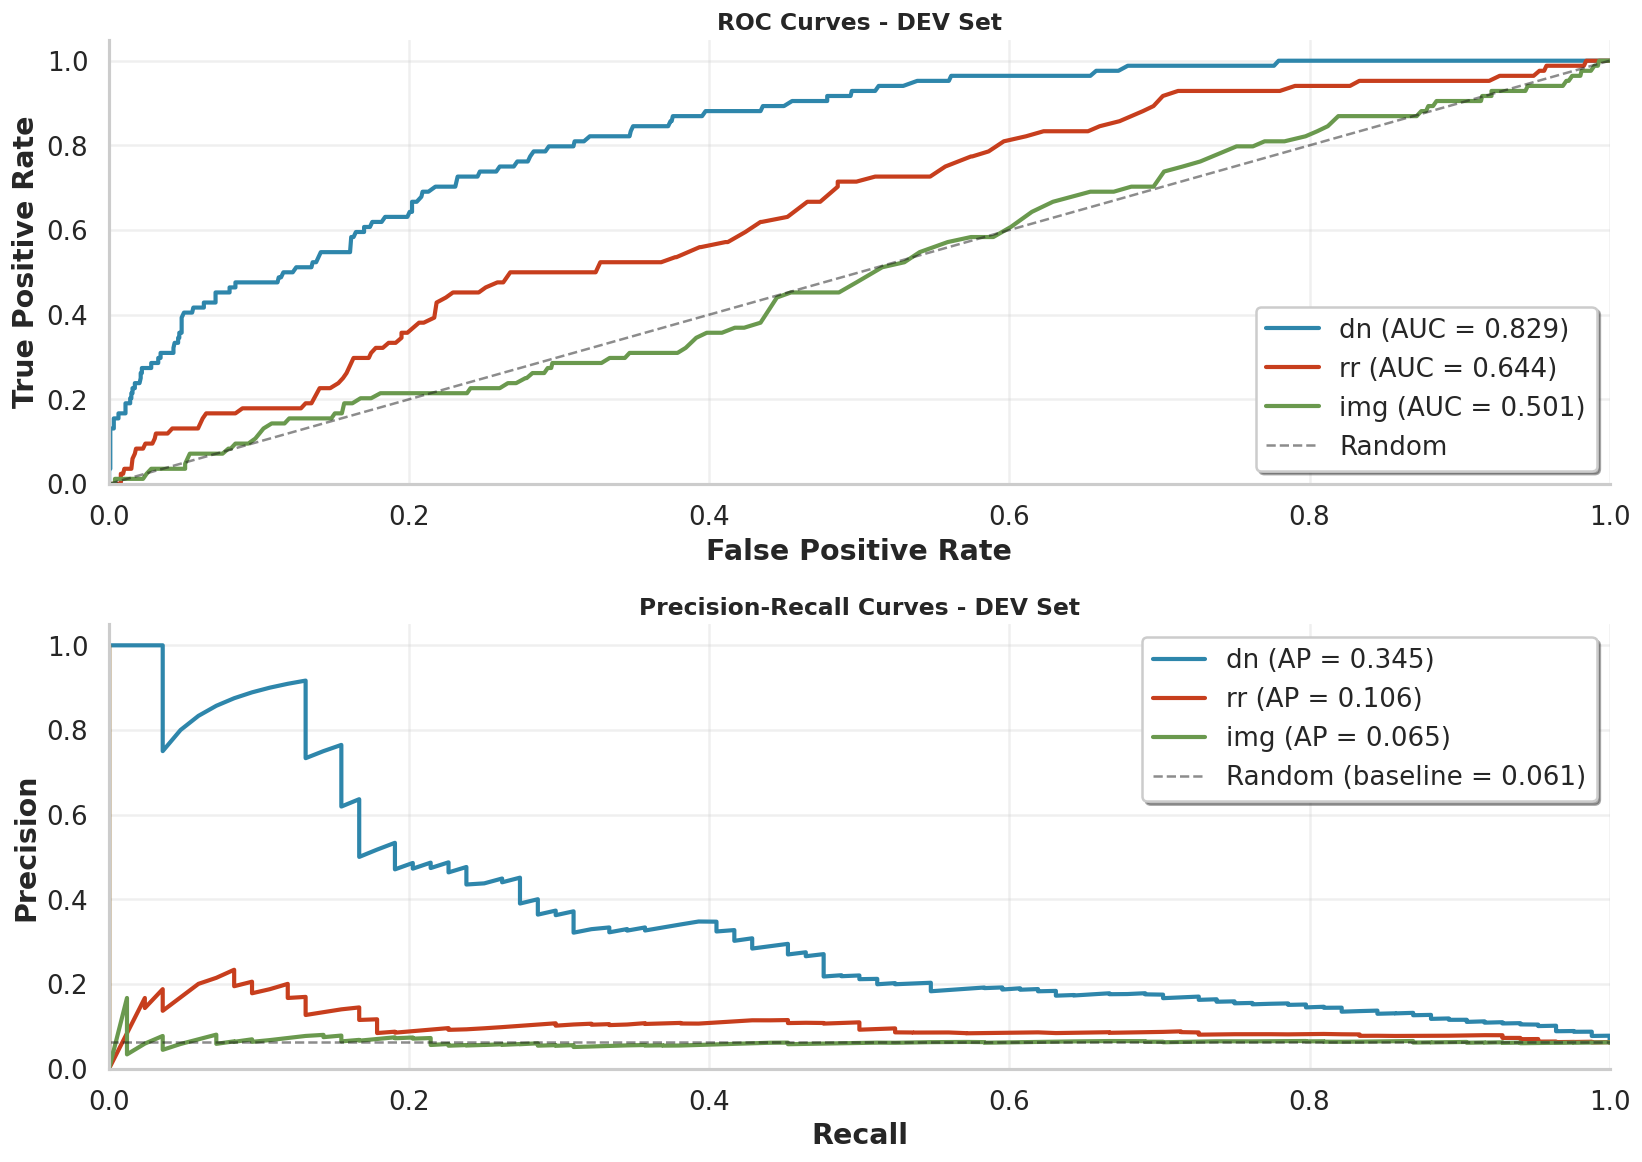

In [ ]:
# -----------------------------
# 1) ROC + PR curves (DEFAULT: test)
# -----------------------------
# Change SPLIT='dev' in the config cell above if you want dev curves.

models_to_compare = MODEL_KEYS

fig = plot_roc_pr_curves(models_to_compare, split=SPLIT, variant='plain', figsize=(14, 10))
plt.show()

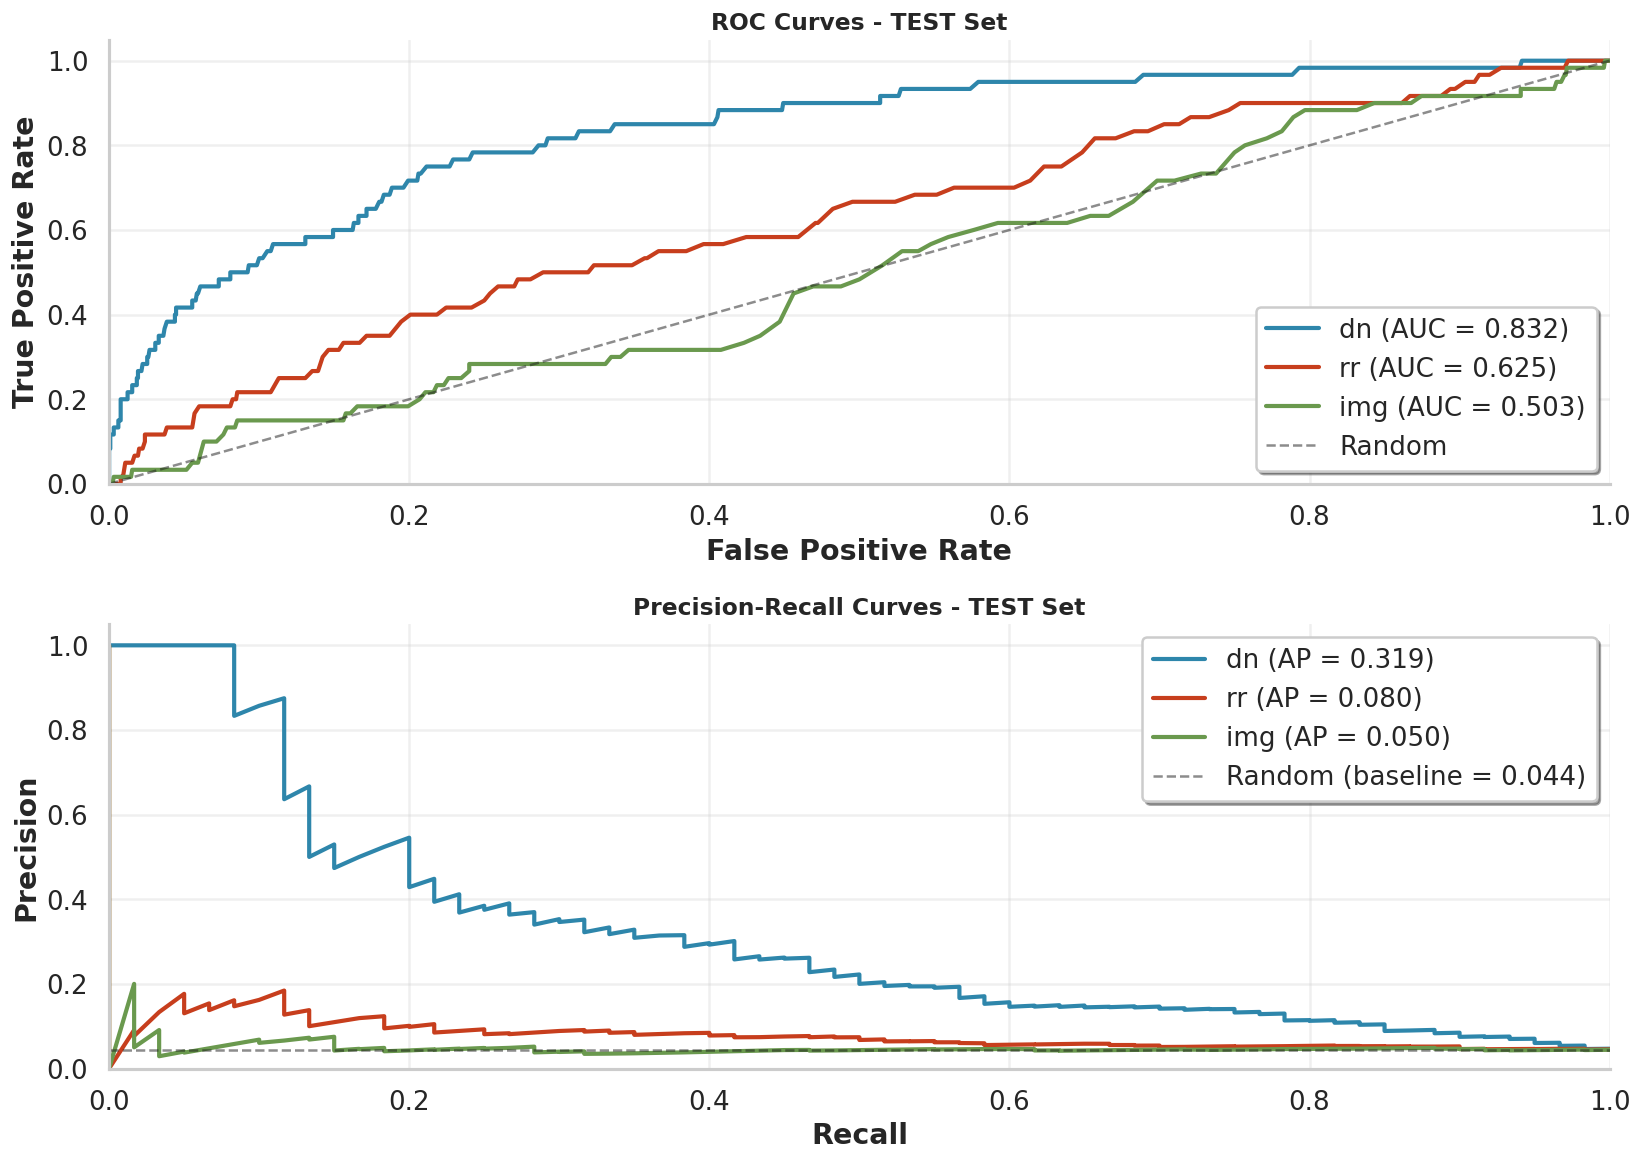

In [ ]:
# (Optional) If you want to plot dev quickly without changing SPLIT globally:
# fig_dev = plot_roc_pr_curves(models_to_compare, split='dev', variant='plain', figsize=(14, 10))
# plt.show()

## 2. Grid Layout: Multiple Comparisons

In [ ]:
def plot_comparison_grid(comparison_groups, split: str = SPLIT, figsize=(20, 12)):
    """Grid of ROC + PR curves.

    comparison_groups can be either:
      - {title: [model_keys]}  (variant assumed 'plain')
      - {title: {'variant': 'plain_add_pi', 'models': [model_keys]}}

    Each column = one group/condition, top row = ROC, bottom row = PR.
    """
    n_groups = len(comparison_groups)
    fig, axes = plt.subplots(2, n_groups, figsize=figsize)
    if n_groups == 1:
        axes = axes.reshape(-1, 1)

    for col_idx, (group_name, group) in enumerate(comparison_groups.items()):
        if isinstance(group, dict):
            variant = group.get('variant', 'plain')
            models = group.get('models', [])
        else:
            variant = 'plain'
            models = group

        ax_roc = axes[0, col_idx]
        ax_pr = axes[1, col_idx]

        y_true_for_baseline = None

        for model_key in models:
            y_true, y_scores = load_predictions(model_key, split=split, variant=variant)
            if y_true is None:
                continue

            y_true_for_baseline = y_true
            color = COLOR_PALETTE.get(model_key, '#333333')
            label_name = MODEL_DISPLAY.get(model_key, model_key)

            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)
            ax_roc.plot(fpr, tpr, color=color, lw=2.5, label=f'{label_name} ({roc_auc:.4f})')

            precision, recall, _ = precision_recall_curve(y_true, y_scores)
            pr_auc = average_precision_score(y_true, y_scores)
            ax_pr.plot(recall, precision, color=color, lw=2.5, label=f'{label_name} ({pr_auc:.4f})')

        ax_roc.plot([0, 1], [0, 1], 'k--', lw=1.2, alpha=0.5)
        ax_roc.set_xlim([0.0, 1.0])
        ax_roc.set_ylim([0.0, 1.05])
        ax_roc.set_title(f'{group_name}\nROC', fontweight='bold')
        ax_roc.grid(True, alpha=0.3)
        ax_roc.legend(loc='lower right', frameon=True, fontsize=9)

        if col_idx == 0:
            ax_roc.set_ylabel('True Positive Rate', fontweight='bold')
        ax_roc.set_xlabel('False Positive Rate', fontweight='bold')

        if y_true_for_baseline is not None:
            pos_rate = float(np.sum(y_true_for_baseline)) / float(len(y_true_for_baseline))
            ax_pr.axhline(y=pos_rate, color='k', linestyle='--', lw=1.2, alpha=0.5)

        ax_pr.set_xlim([0.0, 1.0])
        ax_pr.set_ylim([0.0, 1.05])
        ax_pr.set_title(f'{group_name}\nPR', fontweight='bold')
        ax_pr.grid(True, alpha=0.3)
        ax_pr.legend(loc='upper right', frameon=True, fontsize=9)

        if col_idx == 0:
            ax_pr.set_ylabel('Precision', fontweight='bold')
        ax_pr.set_xlabel('Recall', fontweight='bold')

    plt.suptitle(f'DN / DN+RR / DN+CXR Comparison - {split.upper()} Set', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig

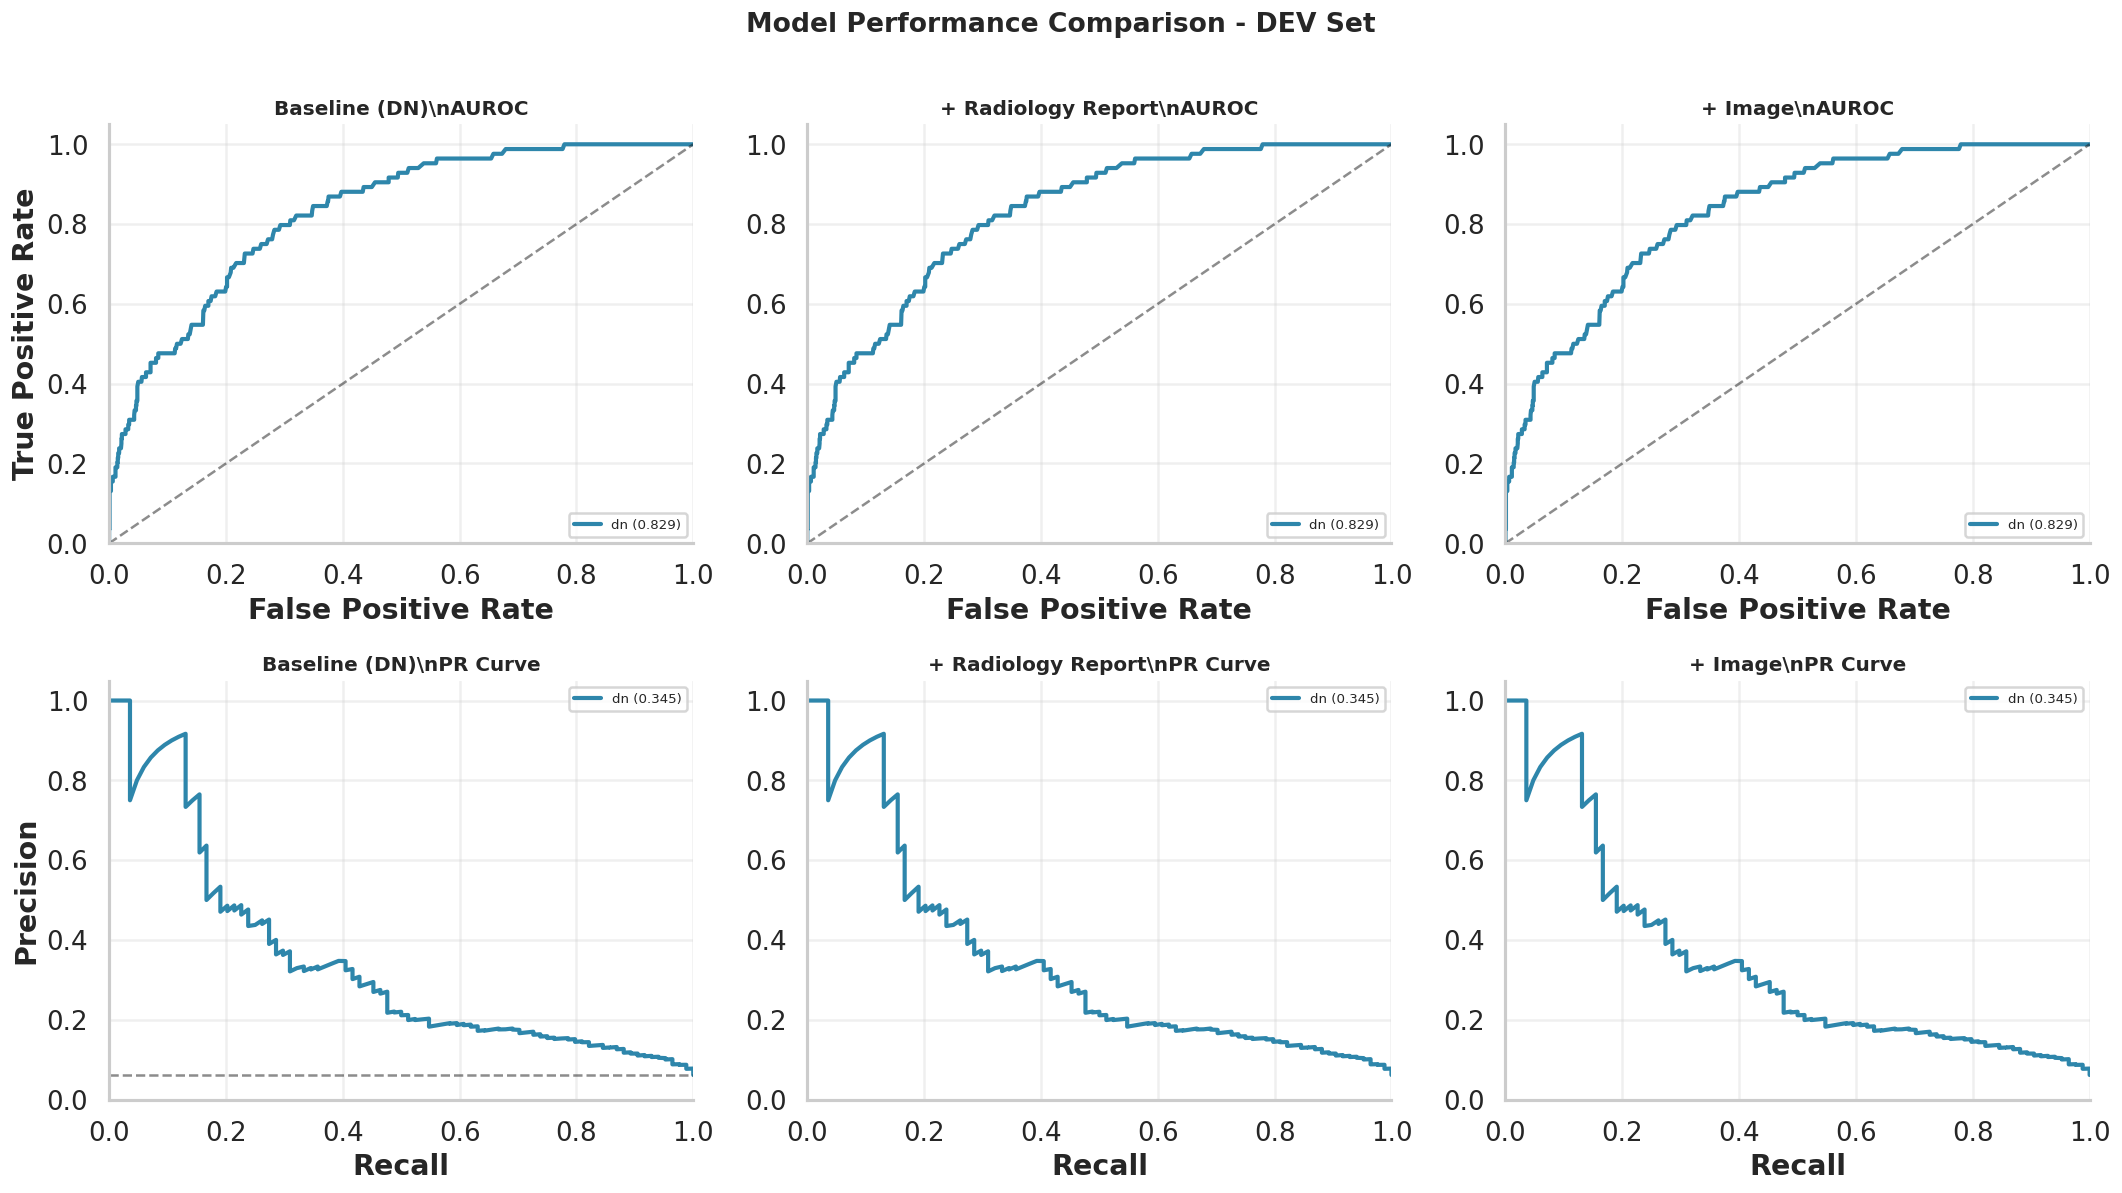

In [ ]:
# -----------------------------
# 2) Grid comparison across 3 conditions
# -----------------------------
# Each column uses a different prediction file variant.
# (If rr/img don't have those variant files yet, you'll see warnings for the missing ones.)

comparison_groups = {
    '-Radiology-related Information': {'variant': 'plain_remove_cxr', 'models': MODEL_KEYS},
    'Baseline': {'variant': 'plain', 'models': MODEL_KEYS},
    '+Patient Demographics': {'variant': 'plain_add_pi', 'models': MODEL_KEYS},
}

fig_grid = plot_comparison_grid(comparison_groups, split=SPLIT, figsize=(18, 10))
plt.show()

## 3. AUROC / AUPRC grouped bar plots (match the example)

- x-axis: **-Radiology-related Information / Baseline / +Patient Demographics**
- hue: **DN / DN+RR / DN+CXR**
- default split: **test** (`SPLIT='test'`), change to `'dev'` to regenerate.

In [ ]:
def collect_condition_metrics(model_keys, split: str = SPLIT):
    """Collect AUROC/AUPRC (+CI) for the 3 conditions and 3 model variants."""
    rows = []

    for model_key in model_keys:
        for variant_key, condition_label in CONDITION_SPECS:
            m = get_metrics(model_key, split=split, variant=variant_key)

            rows.append({
                'Condition': condition_label,
                'ConditionKey': variant_key,
                'ModelKey': model_key,
                'Model': MODEL_DISPLAY.get(model_key, model_key),
                'AUROC': m.get('auroc', np.nan),
                'AUPRC': m.get('auprc', np.nan),
                'AUROC_CI': m.get('auroc_ci', (np.nan, np.nan)),
                'AUPRC_CI': m.get('auprc_ci', (np.nan, np.nan)),
            })

    df = pd.DataFrame(rows)
    # unwrap CI tuples into separate cols
    df[['AUROC_CI_L', 'AUROC_CI_U']] = pd.DataFrame(df['AUROC_CI'].tolist(), index=df.index)
    df[['AUPRC_CI_L', 'AUPRC_CI_U']] = pd.DataFrame(df['AUPRC_CI'].tolist(), index=df.index)
    return df

In [33]:
def plot_metric_bars(df, metric_name='AUROC', figsize=(12, 6)):
    """
    Plot bar chart for a specific metric with confidence intervals
    """
    metric_df = df[df['Metric'] == metric_name].copy()
    
    if len(metric_df) == 0:
        print(f"No data for {metric_name}")
        return None
    
    # Calculate error bars
    metric_df['Error_Lower'] = metric_df['Value'] - metric_df['CI_Lower']
    metric_df['Error_Upper'] = metric_df['CI_Upper'] - metric_df['Value']
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create bar plot
    x_pos = np.arange(len(metric_df))
    colors = [COLOR_PALETTE.get(model, '#777777') for model in metric_df['Model']]
    
    bars = ax.bar(x_pos, metric_df['Value'], 
                  color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add error bars
    ax.errorbar(x_pos, metric_df['Value'],
                yerr=[metric_df['Error_Lower'], metric_df['Error_Upper']],
                fmt='none', ecolor='black', capsize=5, capthick=2, linewidth=2)
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(metric_df.iterrows()):
        ax.text(i, row['Value'] + 0.02, f"{row['Value']:.3f}",
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax.set_ylabel(metric_name, fontweight='bold', fontsize=12)
    ax.set_xlabel('Model', fontweight='bold', fontsize=12)
    ax.set_title(f'{metric_name} Comparison with 95% CI', fontweight='bold', fontsize=14)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(metric_df['Model'], rotation=45, ha='right')
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    return fig

In [34]:
# Collect metrics for all models
models_list = ['dn', 'dn+rr', 'dn+img', 'rr', 'img']

# Dev set
df_dev = collect_metrics(models_list, split='dev')
print("Dev Set Metrics:")
print(df_dev)

# Test set
df_test = collect_metrics(models_list, split='test')
print("\nTest Set Metrics:")
print(df_test)

Dev Set Metrics:
  Model Metric     Value  CI_Lower  CI_Upper
0    dn  AUROC  0.828935  0.786772  0.867485
1    dn  AUPRC  0.344667  0.259920  0.446436
2    rr  AUROC  0.643799  0.585206  0.700658
3    rr  AUPRC  0.105811  0.083242  0.150941
4   img  AUROC  0.501211  0.438987  0.565292
5   img  AUPRC  0.064625  0.054677  0.090728

Test Set Metrics:
  Model Metric     Value  CI_Lower  CI_Upper
0    dn  AUROC  0.844904  0.793429  0.892539
1    dn  AUPRC  0.286569  0.198280  0.405246
2    rr  AUROC  0.625308  0.551559  0.697817
3    rr  AUPRC  0.080257  0.058655  0.127544
4   img  AUROC  0.502718  0.430819  0.576078
5   img  AUPRC  0.050423  0.039783  0.086891


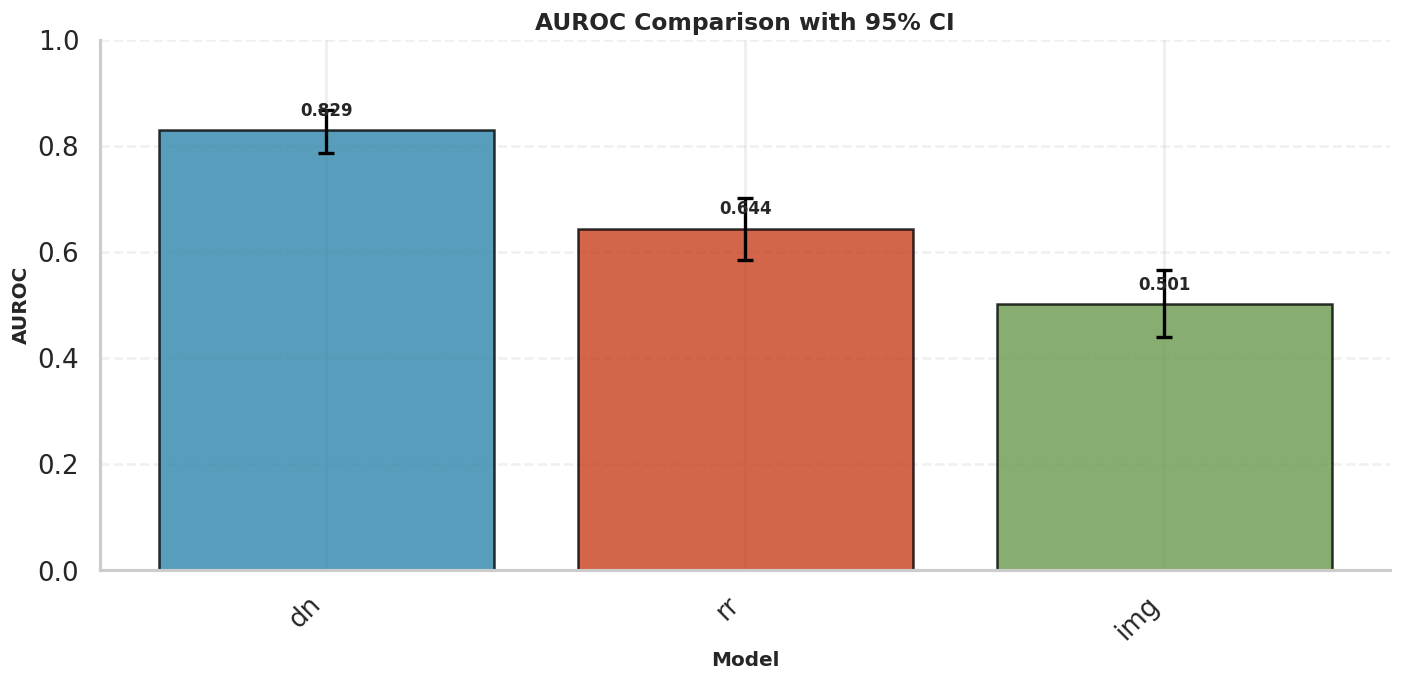

In [ ]:
# Plot AUROC bars - Dev set
fig_auroc_dev = plot_metric_bars(df_dev, metric_name='AUROC', figsize=(12, 6))
if fig_auroc_dev:
    plt.show()

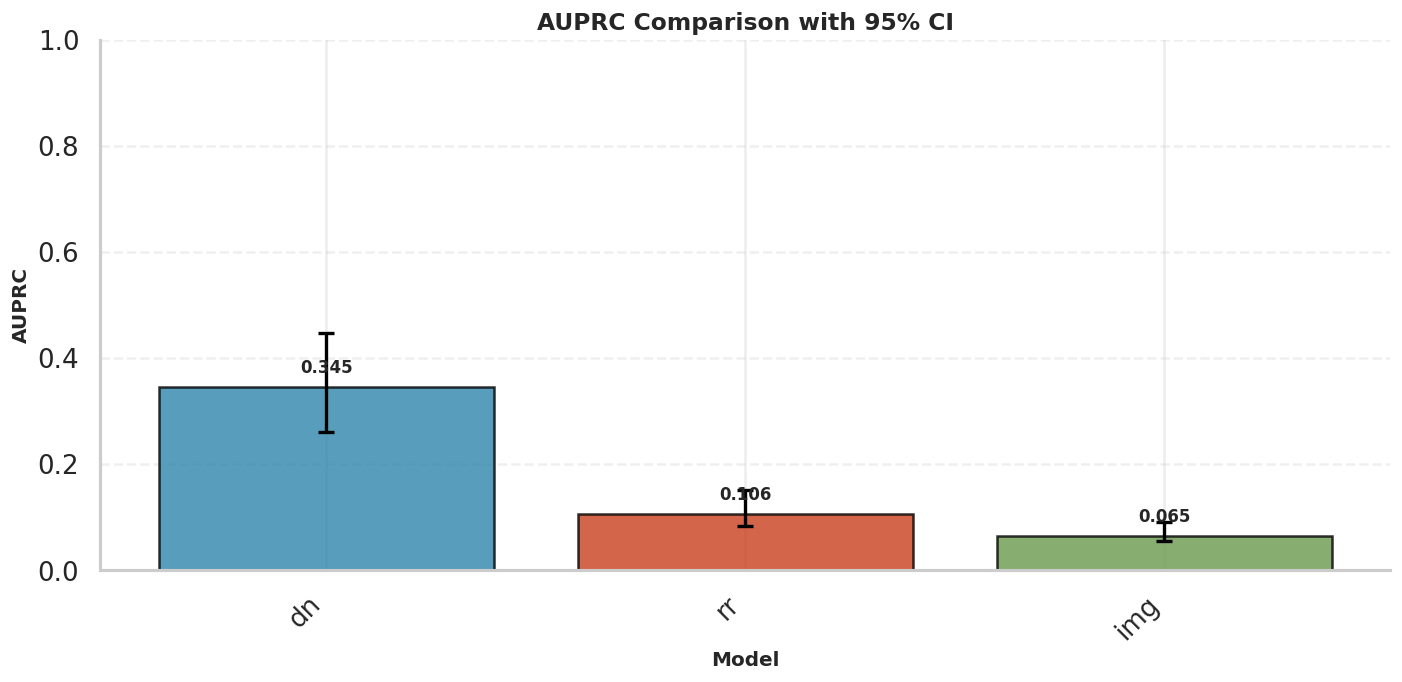

In [36]:
# Plot AUPRC bars - Dev set
fig_auprc_dev = plot_metric_bars(df_dev, metric_name='AUPRC', figsize=(12, 6))
if fig_auprc_dev:
    plt.savefig('/chanhwi/CXR_info_disparity/auprc_bars_dev.png', dpi=300, bbox_inches='tight')
    plt.show()

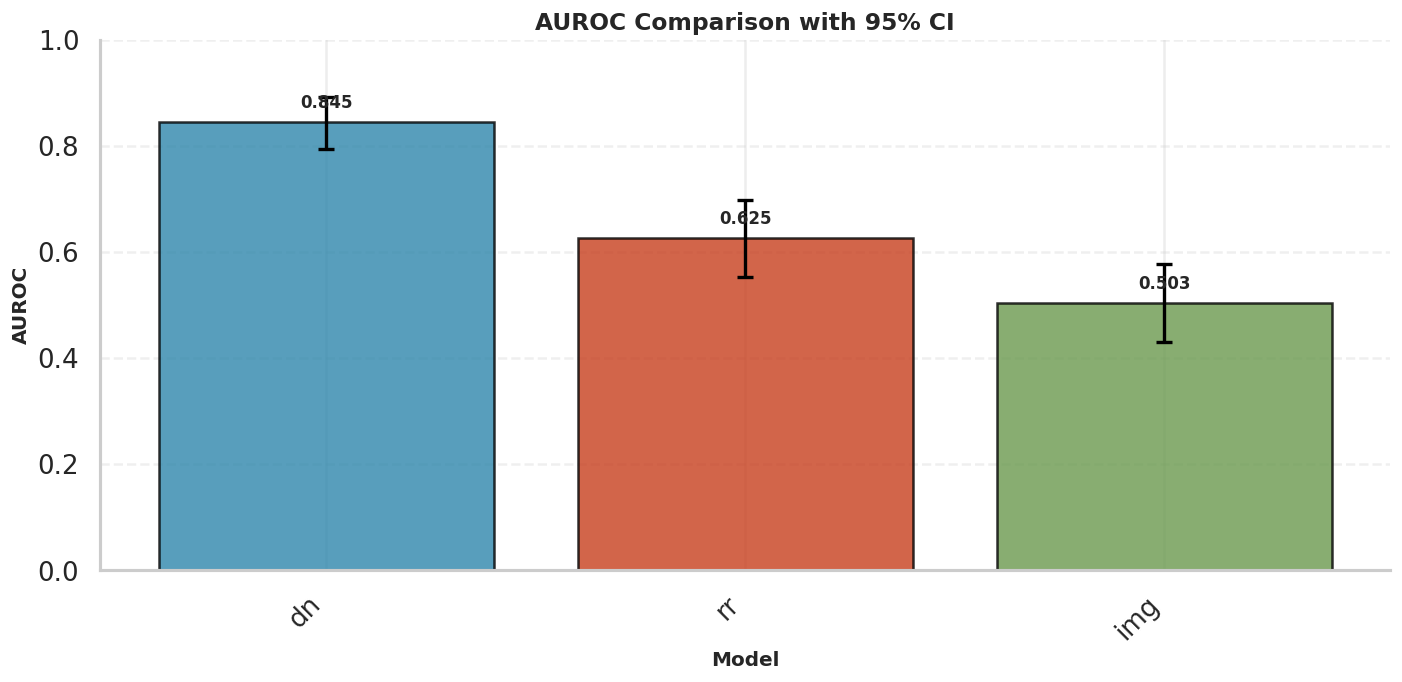

In [ ]:
# Plot AUROC bars - Test set
fig_auroc_test = plot_metric_bars(df_test, metric_name='AUROC', figsize=(12, 6))
if fig_auroc_test:
    plt.show()

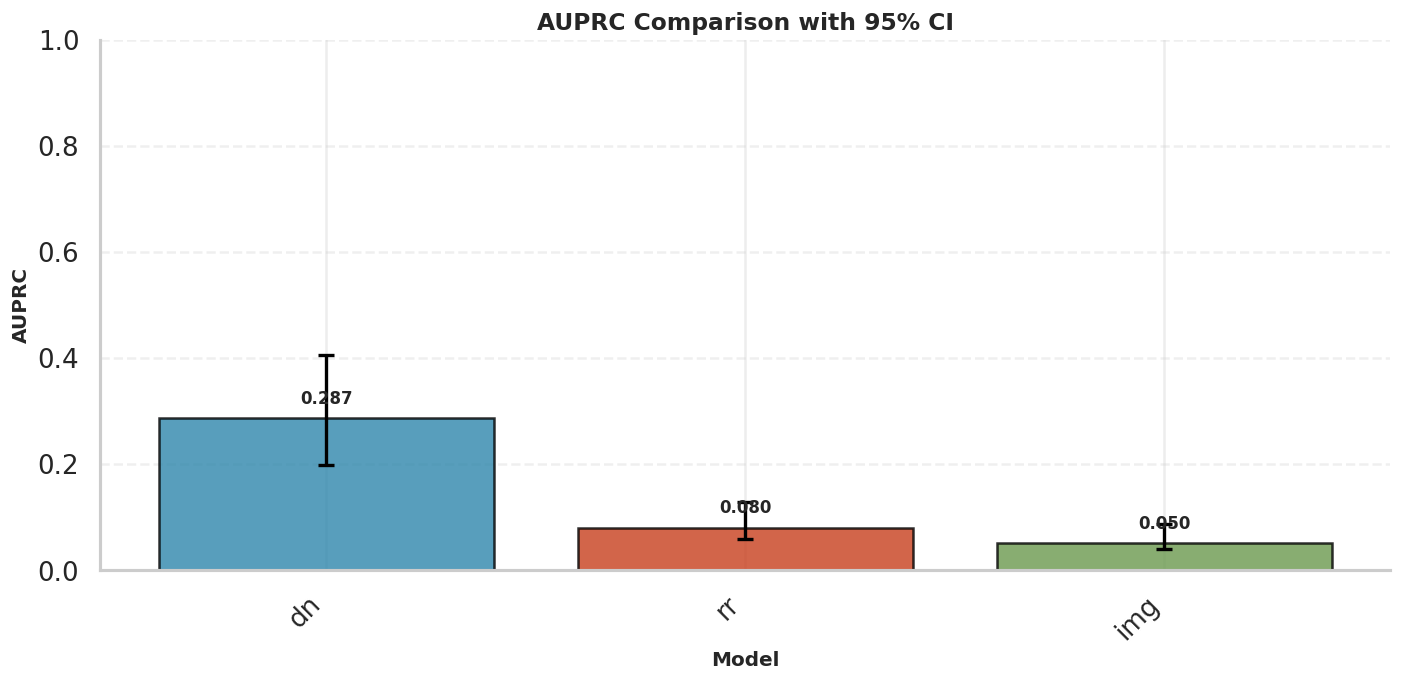

In [ ]:
# Plot AUPRC bars - Test set
fig_auprc_test = plot_metric_bars(df_test, metric_name='AUPRC', figsize=(12, 6))
if fig_auprc_test:
    plt.show()

## 4. Combined Bar Plot (AUROC and AUPRC side-by-side)

In [39]:
def plot_combined_metrics(df, split_name='Dev', figsize=(16, 6)):
    """
    Plot AUROC and AUPRC side by side
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    metrics = ['AUROC', 'AUPRC']
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        metric_df = df[df['Metric'] == metric].copy()
        
        if len(metric_df) == 0:
            continue
        
        # Calculate error bars
        metric_df['Error_Lower'] = metric_df['Value'] - metric_df['CI_Lower']
        metric_df['Error_Upper'] = metric_df['CI_Upper'] - metric_df['Value']
        
        # Create bar plot
        x_pos = np.arange(len(metric_df))
        colors = [COLOR_PALETTE.get(model, '#777777') for model in metric_df['Model']]
        
        bars = ax.bar(x_pos, metric_df['Value'], 
                      color=colors, alpha=0.85, edgecolor='black', linewidth=1.5)
        
        # Add error bars
        ax.errorbar(x_pos, metric_df['Value'],
                    yerr=[metric_df['Error_Lower'], metric_df['Error_Upper']],
                    fmt='none', ecolor='black', capsize=5, capthick=2, linewidth=2)
        
        # Add value labels on bars
        for i, (_, row) in enumerate(metric_df.iterrows()):
            ax.text(i, row['Value'] + 0.02, f"{row['Value']:.3f}",
                    ha='center', va='bottom', fontweight='bold', fontsize=9)
        
        ax.set_ylabel(metric, fontweight='bold', fontsize=12)
        ax.set_xlabel('Model', fontweight='bold', fontsize=12)
        ax.set_title(f'{metric} - {split_name} Set', fontweight='bold', fontsize=13)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(metric_df['Model'], rotation=45, ha='right')
        ax.set_ylim([0, 1.0])
        ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.suptitle(f'Model Performance Metrics - {split_name} Set', 
                 fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig

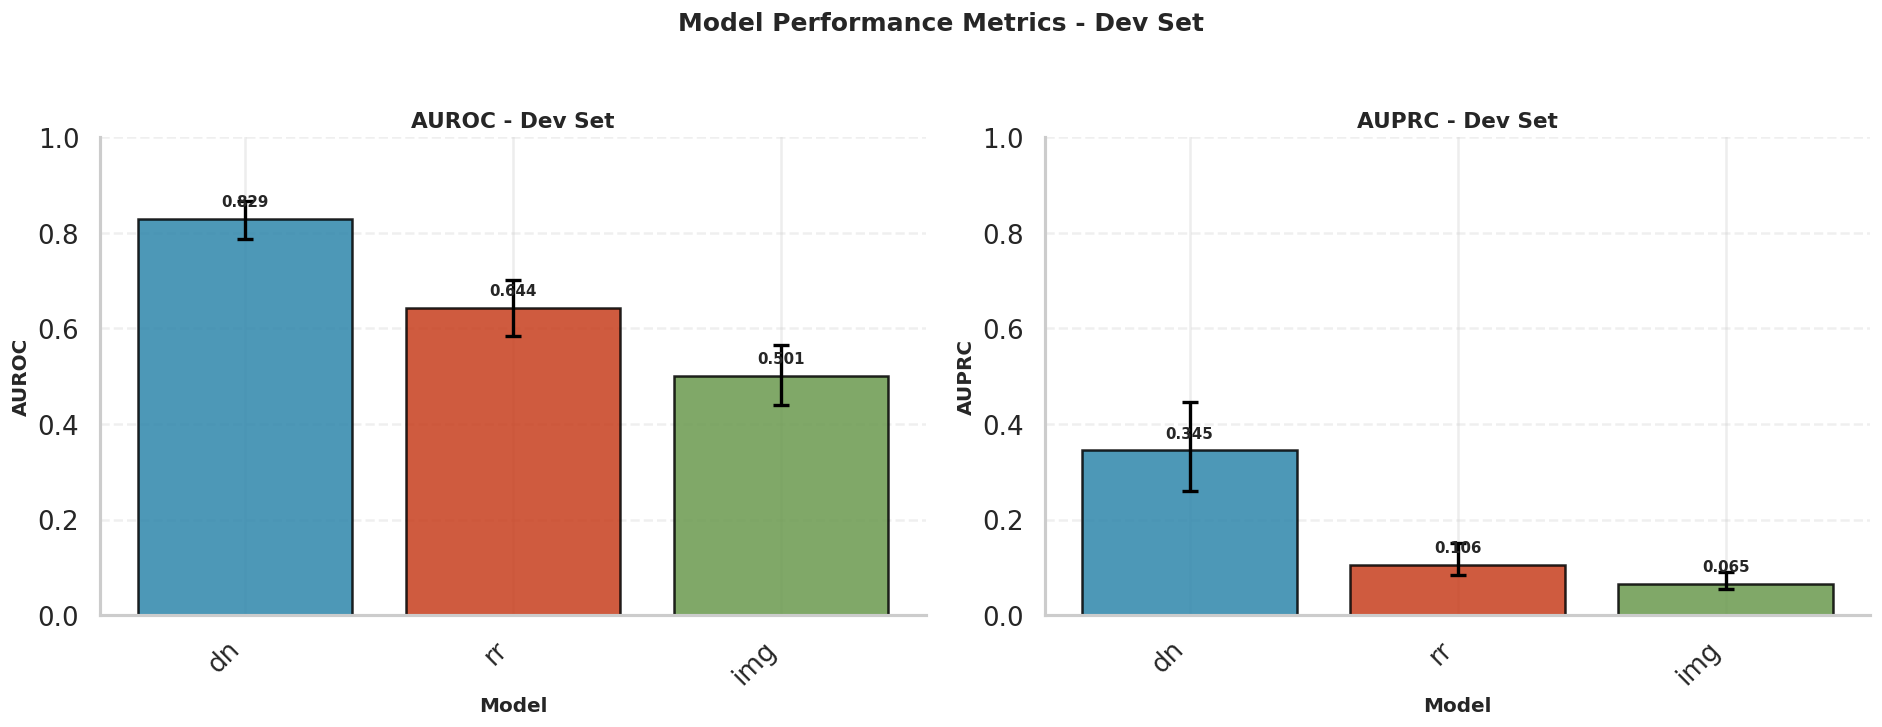

In [40]:
# Combined plot for dev set
fig_combined_dev = plot_combined_metrics(df_dev, split_name='Dev', figsize=(16, 6))
plt.savefig('/chanhwi/CXR_info_disparity/combined_metrics_dev.png', dpi=300, bbox_inches='tight')
plt.show()

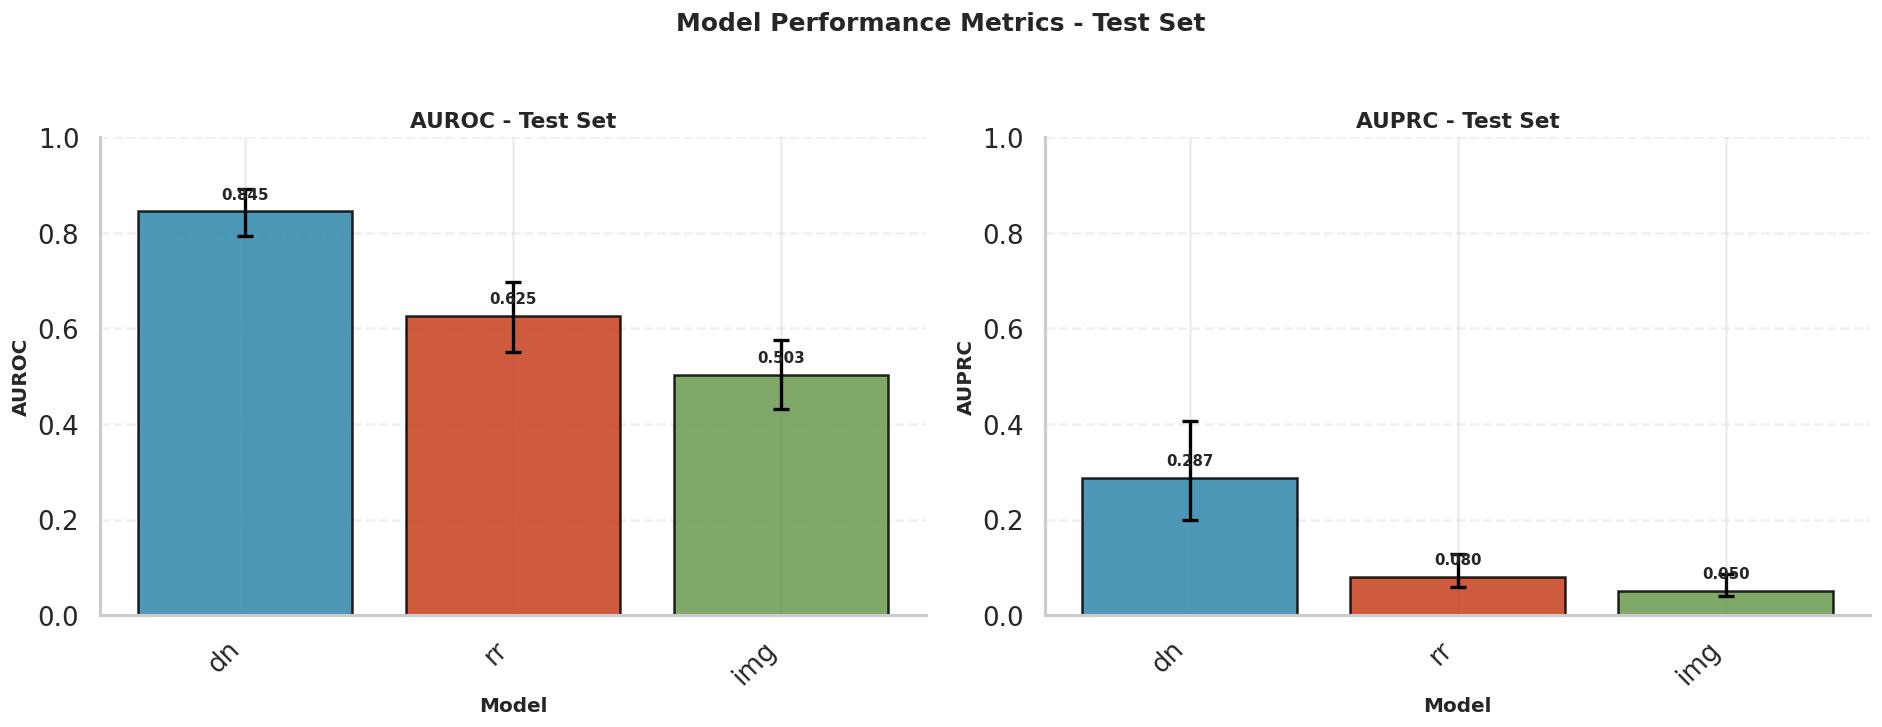

In [41]:
# Combined plot for test set
fig_combined_test = plot_combined_metrics(df_test, split_name='Test', figsize=(16, 6))
plt.savefig('/chanhwi/CXR_info_disparity/combined_metrics_test.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Summary Statistics Table

In [42]:
def create_summary_table(models_list):
    """
    Create a comprehensive summary table
    """
    summary_data = []
    
    for model_name in models_list:
        scores = parse_score_file(model_name)
        if scores is None:
            continue
        
        for split in ['dev', 'test']:
            if split not in scores:
                continue
            
            metrics = scores[split]
            
            auroc = metrics.get('auroc', np.nan)
            auprc = metrics.get('auprc', np.nan)
            auroc_ci = metrics.get('auroc_ci', (np.nan, np.nan))
            auprc_ci = metrics.get('auprc_ci', (np.nan, np.nan))
            
            summary_data.append({
                'Model': model_name,
                'Split': split.upper(),
                'AUROC': f"{auroc:.4f}",
                'AUROC 95% CI': f"({auroc_ci[0]:.4f}, {auroc_ci[1]:.4f})",
                'AUPRC': f"{auprc:.4f}",
                'AUPRC 95% CI': f"({auprc_ci[0]:.4f}, {auprc_ci[1]:.4f})"
            })
    
    return pd.DataFrame(summary_data)

In [ ]:
# Create and display summary table
summary_table = create_summary_table(models_list)
print("\n" + "="*100)
print("MODEL PERFORMANCE SUMMARY")
print("="*100)
print(summary_table.to_string(index=False))
print("="*100)


MODEL PERFORMANCE SUMMARY
Model Split  AUROC     AUROC 95% CI  AUPRC     AUPRC 95% CI
   dn   DEV 0.8289 (0.7868, 0.8675) 0.3447 (0.2599, 0.4464)
   dn  TEST 0.8449 (0.7934, 0.8925) 0.2866 (0.1983, 0.4052)
   rr   DEV 0.6438 (0.5852, 0.7007) 0.1058 (0.0832, 0.1509)
   rr  TEST 0.6253 (0.5516, 0.6978) 0.0803 (0.0587, 0.1275)
  img   DEV 0.5012 (0.4390, 0.5653) 0.0646 (0.0547, 0.0907)
  img  TEST 0.5027 (0.4308, 0.5761) 0.0504 (0.0398, 0.0869)

Summary table saved to: model_performance_summary.csv


## 6. Custom Comparison Groups

You can customize the comparison groups based on your experimental design:

In [44]:
# Example: Custom comparison groups
# Modify this based on your specific comparison needs

custom_groups = {
    'Baseline': ['dn'],
    '- CXR Info': ['rr', 'img'],  # Only radiology report or image
    '+ Personal Info': ['dn+rr', 'dn+img']  # Doctor's note + additional info
}

# You can uncomment and modify as needed:
# fig_custom = plot_comparison_grid(custom_groups, split='dev', figsize=(18, 10))
# plt.savefig('/chanhwi/CXR_info_disparity/custom_comparison.png', dpi=300, bbox_inches='tight')
# plt.show()